In [1]:
# a couple of typical settings just in case they may be useful here, too

# tests with fesom on daily vs monthly gas-ex calculation are found in 
# /home/ollie/jhauck/py_recom/GlobalAssessment/MASTER_gasex_tests_v2.ipynb

# here recaluclate CO2 from model and MPI, Jena pCO2 fields using model gas-exchange output (monthly)

%autosave 10

import sys
import os
sys.path.append('../')

import pandas
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
#import gcb_iav
from annualmean import annualmean
from integrate_CO2flux import integrate_CO2flux
#from regional_average_pCO2 import reg_ave_pCO2  # this one doesn't work (total area is calculated also where there is no data, hence means become too small)

from matplotlib.pyplot import cm
from numpy import genfromtxt #loadtxt
from matplotlib.ticker import MultipleLocator
import seawater as sw
import scipy.signal

import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter



import calendar
import matplotlib.patches as mpatches


# experiments:
# A, B, C

# A: SOCAT only
# B: SOCAT+SOCCOM
# C: ARGO


# Rödenbeck: 1958 - 2019
# Landschützer: 1982 - 2018 (?, 444 monthly entries)


SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Autosaving every 10 seconds
[NbConvertApp] Converting notebook annualmean.ipynb to python
[NbConvertApp] Writing 2130 bytes to annualmean.py
[NbConvertApp] Converting notebook integrate_CO2flux.ipynb to python
[NbConvertApp] Writing 5022 bytes to integrate_CO2flux.py


In [34]:
firstyear=1958
lastyear=2020 # always one more than actually analysed

#define time range for nc data 
gcb_time = np.arange(firstyear,lastyear-1./24,step=1./12)
tsteps = (lastyear-firstyear)*12
gcb_years = np.arange(firstyear,lastyear)



ind1 = 24*12      # start index, monthly time-series, 1982
ind2 = 61*12   # end index, monthly time-series, end 2018

ind = np.where((gcb_years>=2009) & (gcb_years<=2018))

print(tsteps)

# for area-integration:

xax = np.arange(0.5,360.5,1)
yax = np.arange(-89.5,90.5,1)

nx=len(xax)
ny=len(yax)

xi = np.arange(-180,181,1) #longitude
yi = np.arange(-90,91,1) #latitude
Aarea = np.zeros((len(xi)-1,len(yi)-1))

yax2=yax[np.newaxis,:,np.newaxis]
YY = np.tile(yax2,(tsteps,1,nx))

#calculate area
for i in range(0,len(xi)-1): #laenge pruefen!
    for j in range(0,len(yi)-1): #laenge pruefen!
       #sw_dist aus matlab umsetzen
       dist1 = sw.dist([yi[j],yi[j+1]],[xi[i],xi[i]])
       dist2 = sw.dist([yi[j],yi[j]],[xi[i],xi[i+1]])
       Aarea[i][j] = float(dist1[0]) * float(dist2[0]) *1000 *1000 #m2
#flachen ueberall gleich gross?
Aarea = Aarea.transpose()    

areaT = np.tile(Aarea,(tsteps,1,1))

# load reccap regions mask:

regions = Dataset('/work/ollie/jhauck/reccap/RECCAP2-shared-resources/data/regions/RECCAP2_region_masks_all.nc',mode='r')
reg_lon = regions['lon'][:]
reg_lat = regions['lat'][:]
reg_arc = regions['arctic'][:]
reg_arc[reg_arc>0]=1
reg_arcT = np.tile(reg_arc,(tsteps,1,1))

744


In [22]:
# load fields: only need C: ideal Argo sampling grid

# MPI-SOM-FFN:
# spco2:
#land_spco2_1x1_A = np.nan * np.zeros((tsteps,180,360))
#tmp1 = np.load('land_spco2_1x1_A_subsampling.npy')
#land_spco2_1x1_A[ind1:ind2,:,:] = tmp1
##print(np.shape(tmp1))

#land_spco2_1x1_B = np.nan * np.zeros((tsteps,180,360))
#tmp1 = np.load('land_spco2_1x1_B_subsampling.npy')
#land_spco2_1x1_B[ind1:ind2,:,:] = tmp1
##print(np.shape(tmp1))

land_spco2_1x1_C = np.nan * np.zeros((tsteps,180,360))
tmp1 = np.load('land_spco2_1x1_C_subsampling.npy')
land_spco2_1x1_C[ind1:ind2,:,:] = tmp1

land_spco2_1x1_A = np.nan * np.zeros((tsteps,180,360))
tmp1 = np.load('land_spco2_1x1_A_subsampling.npy')
land_spco2_1x1_A[ind1:ind2,:,:] = tmp1
#print(np.shape(tmp1))

print(np.shape(land_spco2_1x1_C))


# Jena-MLS:

# spco2:
# gridded fields
#roeden_spco2_1x1_A = np.load('roeden_spco2_1x1_A_subsampling.npy')
#roeden_spco2_1x1_B = np.load('roeden_spco2_1x1_B_subsampling.npy')

# with Schmidt number
tmp = np.load('roedenSc_spco2_1x1_C_subsampling.npy')
roeden_spco2_1x1_C = np.copy(tmp[0:tsteps,:,:])

tmp = np.load('roedenSc_spco2_1x1_A_subsampling.npy')
roeden_spco2_1x1_A = np.copy(tmp[0:tsteps,:,:])

print(np.shape(roeden_spco2_1x1_C))

# model :
# pco2

in_data = Dataset('/work/ollie/jhauck/subsampling/fesom/from_cara/spco2_fesom_A_reg_1958_2019.nc',mode='r')

spco2_fesom = in_data['spco2'][:]
fesom_lon = in_data['Lon'][:]
fesom_lat = in_data['Lat'][:]
fesom_time = in_data['Time'][:]

# check whether it starts at 0 deg:
print(min(fesom_lon),min(fesom_time),np.shape(spco2_fesom))

# again trouble with negative numbers (ha, no data types trouble this time)
ftest = np.copy(spco2_fesom.data)
ftest[ftest<0]=np.nan

# then model sos, tos, kw660, aCO2:
in_data = Dataset('/work/ollie/jhauck/subsampling/fesom/from_cara/Kw_fesom_A_reg_1958_2019.nc',mode='r')
kw660 = in_data['Kw'][:]

in_data = Dataset('/work/ollie/jhauck/subsampling/fesom/from_cara/sos_fesom_A_reg_1958_2019.nc',mode='r')
sos = in_data['sos'][:]

in_data = Dataset('/work/ollie/jhauck/subsampling/fesom/from_cara/tos_fesom_A_reg_1958_2019.nc',mode='r')
tos = in_data['tos'][:]

in_data = Dataset('/work/ollie/jhauck/subsampling/fesom/from_cara/pco2atm_fesom_A_reg_1958_2019.nc',mode='r')
pco2atm = in_data['pco2atm'][:]


in_data = Dataset('/work/ollie/jhauck/subsampling/fesom/from_cara/alphaCO2_fesom_A_1_gr_1958-2019_v20220502.nc',mode='r')
alpha = in_data['alphaCO2'][:]


(744, 180, 360)
(744, 180, 360)
0.5 1339200.0 (744, 180, 360)


In [23]:
# calculate density and Schmidt number:

#------------------------------------------------------------------------------------
# for Schmidt number, taken from Luke; same is used in mocsy
#!  Compute Schmidt number of CO2 in seawater w/ formulation from Wanninkhof (Limnol. Oceanogr.: Methods 12, 2014, 351–362)                                             

a = +2116.8
b = -136.25
c = +4.7353
d = -0.092307
e = +0.0007555

rhosw = sw.dens0(sos,tos)
Sc = a + b * tos + c * tos ** 2 + d * tos ** 3 + e * tos ** 4

# include Schmidt number in kw value
kwco2 = kw660 * (660/Sc)**0.5



In [24]:
# calculate gas-ex

# units: 

# kw: m / s
# alpha: mol / kg / atm
# rhosw: kg / m3
# dpco2: muatm

# 1 /s * mol /m2 /atm * muatm 


# for mol / m2/yr
conv_molm2yr = -1e-6*24*365*60*60

# for mol / m2/s
conv_molm2s = -1e-6 # uptake positive

# kwco2 now includes Schmidt number
gasex_fesom = kwco2 * alpha * rhosw * (spco2_fesom - pco2atm) *conv_molm2s

# roeden
gasex_roeden = kwco2 * alpha * rhosw * (roeden_spco2_1x1_C - pco2atm) *conv_molm2s
gasex_roeden_A = kwco2 * alpha * rhosw * (roeden_spco2_1x1_A - pco2atm) *conv_molm2s

gasex_roeden_660 = kw660 * alpha * rhosw * (roeden_spco2_1x1_C - pco2atm) *conv_molm2s


# land
gasex_land = kwco2 * alpha * rhosw * (land_spco2_1x1_C - pco2atm) *conv_molm2s
gasex_land_A = kwco2 * alpha * rhosw * (land_spco2_1x1_A - pco2atm) *conv_molm2s


/work/ollie/jhauck/gcp2018/py_recom/GCB/code/2021/subsampling/integrate_CO2flux.py:27: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad('white',1.)


shape(reg_arcT) (744, 180, 360)
region glo_noArc
shape(mask) (744, 180, 360)


/work/ollie/jhauck/gcp2018/py_recom/GCB/code/2021/subsampling/integrate_CO2flux.py:116: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(reg_lon,reg_lat,np.squeeze(mask[1,:,:]))#, vmin=-60, vmax=750)


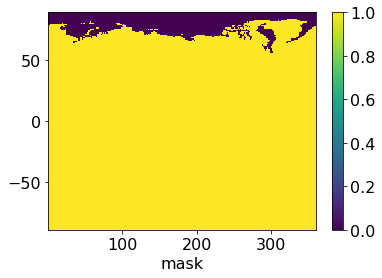

glo_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [1.085091318501533 0.49904586807352674 0.577114799626154
 0.9159230017345876 0.7126704582594 0.8011590007274384 0.9257511152577003
 0.9557326937554256 0.6921967527273024 1.1734739454529948
 1.160690861836366 1.4591210957477645]
1 [1.0585117134105997 0.8365713572757402 0.9624078697282992
 0.9393831768330029 0.9149420899750176 1.2226177334358885
 1.149320985129868 1.0587172864296597 0.8895253381853748
 1.2119784800194848 1.7819091480291596 1.677458537042767]
2 [1.322071377850658 0.88733892119372 0.8680635322704262 1.104774903689619
 1.1860021819197806 1.243935685879528 1.4380513544376357
 0.8100466801001508 1.0846308566349094 1.0679468880044913
 1.5331916048010141 1.6634302180059934]
3 [1.1996615490060683 0.9525378315907513 0.8203481657328916
 0.9020980498546667 0.9135394521357785 1.0417791479186893
 1.0832850817474056 0.9176837366545143 0.7429069467377306
 1.3080694344310861 1.3935242367148681 1.5738282299

shape(reg_arcT) (744, 180, 360)
region N_noArc
shape(mask) (744, 180, 360)


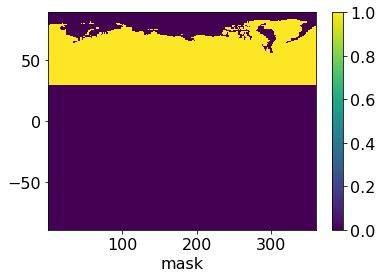

N_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [1.9635107799495435 1.8440347157336785 1.7826032149036926
 1.6284296180165305 0.9860890817416591 0.3415589262317319
 -0.15817166464085772 -0.4449454829706377 -0.39710559530500505
 0.16680413180045764 0.8247908267792836 1.5198891198818503]
1 [1.8393669231450738 1.9000389965609228 2.012939428878323
 1.6098195555017196 0.9604366265396485 0.4693628661430726
 -0.1335703487493312 -0.4115083875335051 -0.3603496282298208
 0.2518523733819073 1.0501867113972476 1.6154297883647637]
2 [1.7613335214290204 1.8517382419977002 1.7907735865497654
 1.5688177901882083 1.0676168881974484 0.4538500984435675
 -0.12436724207551954 -0.46814407842200284 -0.31261167068722595
 0.09378110655459466 0.9436328017886288 1.6107519948961648]
3 [1.8822221715315957 2.0116230358433076 1.908079308152378
 1.5830897421851935 1.044551603580571 0.3715447587799543
 -0.20235014538617585 -0.43261435284070393 -0.3481189849433176
 0.1848888223714756 0.8

shape(reg_arcT) (744, 180, 360)
region T
shape(mask) (744, 180, 360)


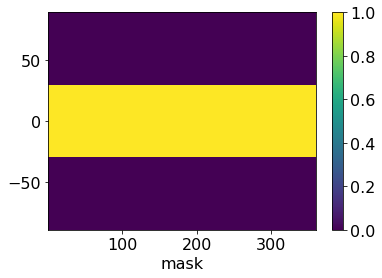

T
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.7008484033123128 -0.8865929623145914 -0.7872974160578838
 -0.8017693091368965 -0.9412451274657379 -0.8029403505557535
 -0.4746441243117505 -0.3093207253265449 -0.4474827793078904
 -0.5159251512434884 -0.6745560358915909 -0.5921269431658013]
1 [-0.6679000363205106 -0.5832920591585907 -0.6415894922381947
 -0.7116365048600015 -0.6542167852513605 -0.39830288894509974
 -0.26666473711814076 -0.21333822807483296 -0.3003713314702449
 -0.5121937642730033 -0.48213469036020856 -0.545302453638181]
2 [-0.4325720507853595 -0.5017933023534824 -0.500459565507844
 -0.5350183336797409 -0.6356280387907424 -0.4733742649197338
 -0.1617643219140073 -0.2149272784456523 -0.2221988278464275
 -0.4220917507120373 -0.5510785103256894 -0.4738160786287383]
3 [-0.5173187355664123 -0.6023362654682543 -0.6379166334116038
 -0.6146047286334623 -0.6608152248525688 -0.5843986080851021
 -0.29276150704398574 -0.24379222968451827 -0.472362697855121

shape(reg_arcT) (744, 180, 360)
region S
shape(mask) (744, 180, 360)


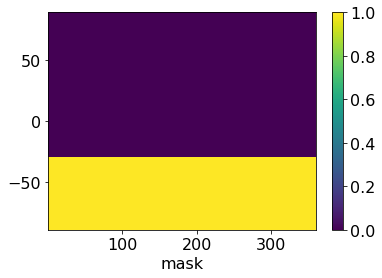

S
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.17757105813569762 -0.4583958853455604 -0.4181909992196543
 0.08926269285495363 0.6678265039834789 1.2625404250514602
 1.5585669042103083 1.7099989020526085 1.536785127340198
 1.5225949648960257 1.0104560709486734 0.5313589190317153]
1 [-0.11295517341396298 -0.4801755801265916 -0.4089420669118293
 0.041200126191284867 0.6087222486867296 1.1515577562379156
 1.54955607099734 1.6835639020379973 1.5502462978854408 1.472319870910581
 1.2138571269921206 0.6073312023161845]
2 [-0.006690092793003212 -0.4626060184504976 -0.422250488771495
 0.07097544718115167 0.7540133325130747 1.2634598523556944
 1.7241829184271624 1.4931180369678057 1.6194413551685631
 1.3962575321619337 1.140637313338075 0.5264943017385673]
3 [-0.16524188695911526 -0.45674893878430234 -0.44981450900788256
 -0.06638696369706482 0.5298030734077761 1.254632997223837
 1.5783967341775673 1.5940903191797366 1.5633886295361705
 1.5298961820095103 1.0840149

shape(reg_arcT) (744, 180, 360)
region glo_noArc
shape(mask) (744, 180, 360)


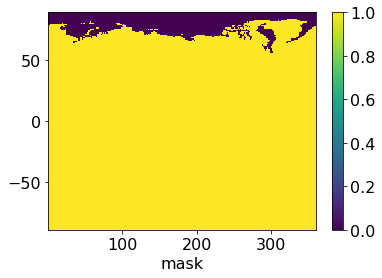

glo_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [1.7344207532914464 1.0692628962099258 1.111201082295993
 1.5006312367247407 1.180015398408046 1.2310831188419256
 1.3621760434548833 1.3920664881616844 1.1084199577144058
 1.748137051351908 1.7833237551217322 2.145047369615573]
1 [1.7147407553692764 1.4649900802923428 1.587354431887235 1.455963676596934
 1.303295645448608 1.600834683943275 1.5015691718493365 1.46594186608345
 1.2960170530332504 1.7386998733227053 2.5140511728180126
 2.4325170730169607]
2 [1.9605324692569064 1.456115847830088 1.3447665189478961
 1.6292027630791739 1.692741627715433 1.6117100280275076
 1.8046443031539525 1.1256251910952595 1.4692553980904806
 1.5402802973816554 2.206395447268539 2.3738169192491454]
3 [1.854077818804184 1.5952563812018037 1.4094017842495972
 1.3838017467847905 1.3730009763491142 1.4368984832108072
 1.4421183900507493 1.3037520555678062 1.170426849644621
 1.8635307516263881 2.0419947291527296 2.2838861348917

shape(reg_arcT) (744, 180, 360)
region N_noArc
shape(mask) (744, 180, 360)


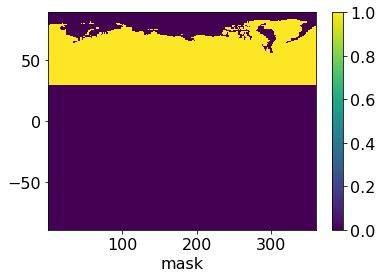

N_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [2.4955419387065922 2.3208781278952517 2.2906412428028164
 2.138080235031266 1.2975777057269324 0.45766197965612365
 -0.12887030733870375 -0.4282287881152196 -0.3827227342990695
 0.27417966988091036 1.0737738808943014 1.9279984211126922]
1 [2.3463346748705964 2.4781055311083025 2.6274510758021665
 2.1308609335434014 1.2721319440802625 0.6329640265081993
 -0.10163699069645452 -0.392088801240514 -0.31971669713152834
 0.37059228506105996 1.3556648148133703 2.091326612195008]
2 [2.2349629985933697 2.365591662313298 2.3010840528484726 2.078839829668612
 1.4144514533516148 0.5974331579997608 -0.10016231808474069
 -0.46695036659894545 -0.28374126762836493 0.17218294497344802
 1.2144866418571023 2.0723723640472054]
3 [2.4239398263786494 2.5836969851447034 2.505401468856152
 2.0921189824281026 1.3898492983999213 0.5097401099453125
 -0.172218934442215 -0.41480533373999406 -0.30544633349747385
 0.2941507494877582 1.11

shape(reg_arcT) (744, 180, 360)
region T
shape(mask) (744, 180, 360)


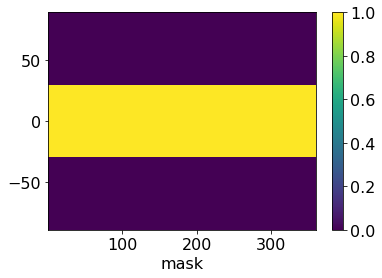

T
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.592908457315705 -0.7313563947170193 -0.6389154146440628
 -0.665851397261689 -0.794387314068628 -0.6625197133925183
 -0.35488185218134555 -0.19864245162347743 -0.32372659797926356
 -0.4055956775490696 -0.5864499043171828 -0.5148721350781326]
1 [-0.5608994265666836 -0.4764005941429747 -0.5163955576299127
 -0.5913537346937857 -0.5464139344912158 -0.3074344720048012
 -0.17835139309450304 -0.11788383139791811 -0.20140562962424866
 -0.42176534761115003 -0.41260715115471397 -0.47924815828489453]
2 [-0.3509699908223813 -0.39742193174917384 -0.3966132721631567
 -0.4375619827277743 -0.5327911126493751 -0.38060755280849384
 -0.08355761029317124 -0.11348658993505673 -0.1287805883581664
 -0.3407137187500522 -0.47725923594246655 -0.40980777326019857]
3 [-0.43163915150984944 -0.4812697221344795 -0.5224459142924307
 -0.5105386417548432 -0.5566215699047288 -0.4949236517871839
 -0.21711889336101245 -0.16029937009896328 -0.3811

shape(reg_arcT) (744, 180, 360)
region S
shape(mask) (744, 180, 360)


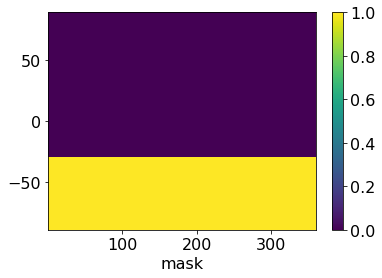

S
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.16821272809944104 -0.5202588369683071 -0.5405247458627607
 0.028402398955163437 0.6768250067497416 1.4359408525783202
 1.8459282029749329 2.018937727900381 1.8148692899927388
 1.8795530590200673 1.2959997785446133 0.7319210835810142]
1 [-0.07069449293463696 -0.5367148566729845 -0.5237010862850189
 -0.08354352225268147 0.5775776358595613 1.2753051294398767
 1.7815575556402943 1.9759144987218817 1.8171393797890274
 1.789872935872795 1.570993509159356 0.8204386191068479]
2 [0.07653946148591796 -0.5120538827340364 -0.5597042617374195
 -0.012075083861663583 0.811081287013193 1.394884422836241
 1.9883642315318644 1.706062147629262 1.881777254077012 1.7088110711582596
 1.4691680413539037 0.7112523284621384]
3 [-0.13822285606461593 -0.50717088180842 -0.5735537703141239
 -0.19777859388846908 0.5397732478539218 1.4220820250526784
 1.8314562178539766 1.8788567594067638 1.857065976677551
 1.9057579526520128 1.41853081273

shape(reg_arcT) (744, 180, 360)
region glo_noArc
shape(mask) (744, 180, 360)


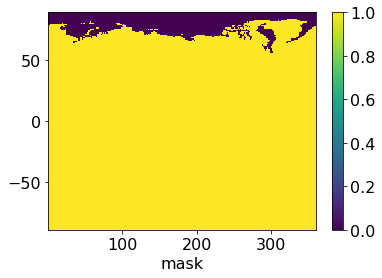

glo_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [0.10559009556210759 -0.6025350962881975 -0.4698993770770624
 -0.0724809235913814 -0.30111650160595904 -0.21748288055415516
 0.07801852556070756 0.23010977833512225 0.2562245841073647
 0.8410109124386981 0.7962836487881335 1.0432011163413295]
1 [0.5218228420376528 0.08861903915307778 0.1611357544608484
 0.13410347314364582 0.07273940392205686 0.33514358873139494
 0.36458026790525333 0.377387405718326 0.38949593360005164
 0.7997249945379509 1.349863540777259 1.202758689048723]
2 [0.8790132764580189 0.2441773665816722 0.24592800855648128
 0.3679482670122991 0.2985856913873563 0.2832982471522009
 0.5175949016494443 0.09098217140338281 0.5395239468312233
 0.630836968872505 1.027666203268788 1.2500234644557893]
3 [0.7918832622932781 0.3986895038617317 0.26195035606175143
 0.3711352328789813 0.29170360530061357 0.19887472612767182
 0.26790516926427504 0.25785688192896233 0.2947747332133923
 1.0261486610295205 1

shape(reg_arcT) (744, 180, 360)
region N_noArc
shape(mask) (744, 180, 360)


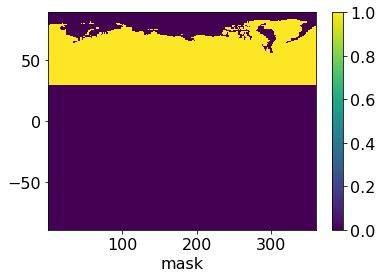

N_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [1.6933081936340453 1.6219977654342712 1.6047482311605186
 1.5206951416936647 0.9023976261361224 0.2569983193656958
 -0.29168513071742735 -0.630970598114944 -0.5683670138557902
 0.011889375379191304 0.7326889412440674 1.4369660969234908]
1 [1.7611422386025402 1.7784355001075738 1.9199795936961952 1.53763567307805
 0.8911110273245337 0.3580325461112622 -0.268775163855768
 -0.6176062523408204 -0.5891154723563757 0.07212310520944461
 0.9363492721017928 1.5957915226970516]
2 [1.815292887548686 1.8791710123832914 1.863256870004963 1.5979149584645331
 1.0280630395642938 0.3460945658114491 -0.26645697661460194
 -0.6595962680565475 -0.5057520319284196 -0.0633525895344314
 0.8106254671696694 1.538784011793371]
3 [1.8540500276479197 1.9633501790030228 1.8732757287942747
 1.5750440271510886 1.0307793785030817 0.31524688401060647
 -0.2957332577761506 -0.577468287030656 -0.5119561467290079
 0.10043464397849615 0.8024501

shape(reg_arcT) (744, 180, 360)
region T
shape(mask) (744, 180, 360)


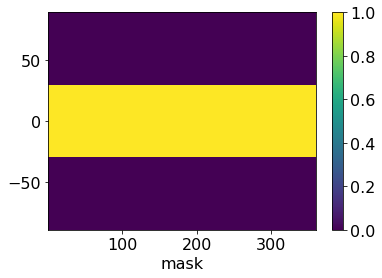

T
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.9303064438211625 -1.1735724608038078 -0.9796773943285872
 -1.0129541997672264 -1.2180922410300208 -1.1291190256937156
 -0.7879106159509104 -0.5921387222019755 -0.6353049021231214
 -0.6626151603909496 -0.8402291561338819 -0.7571659831427181]
1 [-0.9230406856232388 -0.8909616273669759 -0.9621088893371567
 -1.0721689771618526 -1.0538589246800798 -0.8087893622570085
 -0.6599502880915328 -0.5986129595897939 -0.6465912305566535
 -0.796472629795169 -0.7768835738292112 -0.8650912763398901]
2 [-0.7327361006794897 -0.8484600249317433 -0.8209812727696232
 -0.8717870496400941 -1.0477078379273195 -0.9551654994725456
 -0.629694584822857 -0.6551372920303018 -0.5768968882687573
 -0.7194227100890563 -0.8441522690068025 -0.7317828419562985]
3 [-0.8151366301172122 -0.9341965895072523 -0.9133591860594095
 -0.9046644630838073 -1.0364308935477184 -1.0574975894518082
 -0.737613794635651 -0.6504474684197541 -0.7837368030171736
 -0.6

shape(reg_arcT) (744, 180, 360)
region S
shape(mask) (744, 180, 360)


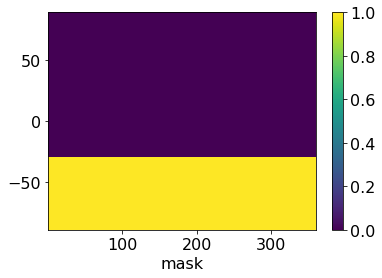

S
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.6574116542507745 -1.0509604009186608 -1.0949702139089939
 -0.5802218655178197 0.014578113287939513 0.6546378257738645
 1.1576142722290454 1.4532190986520421 1.459896500086277
 1.4917366974504567 0.9038238636779481 0.3634010025605569]
1 [-0.3162787109416482 -0.7988548335875201 -0.79673494989819
 -0.33136322277255154 0.23548730127760314 0.7859004048771411
 1.2933057198525544 1.5936066176489403 1.6252026365130807
 1.5240745191236753 1.1903978425046773 0.4720584426915618]
2 [-0.2035435104111775 -0.7865336208698767 -0.7963475886788588
 -0.35817964181214 0.3182304897503819 0.8923691808132974
 1.4137464630869034 1.405715731490232 1.6221728670284006
 1.4136122684959924 1.061193005105921 0.4430222946187166]
3 [-0.2470301352374297 -0.6304640856340382 -0.6979661866731138
 -0.29924433118829996 0.2973551203452507 0.9411254315688734
 1.3012522216760765 1.4857726373793723 1.5904676829595739
 1.5686320934780007 1.02928029726

shape(reg_arcT) (744, 180, 360)
region glo_noArc
shape(mask) (744, 180, 360)


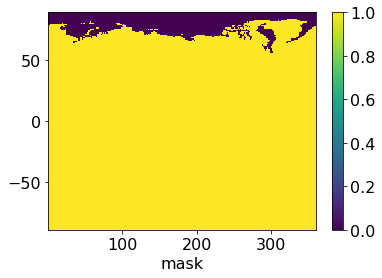

glo_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- 

shape(reg_arcT) (744, 180, 360)
region N_noArc
shape(mask) (744, 180, 360)


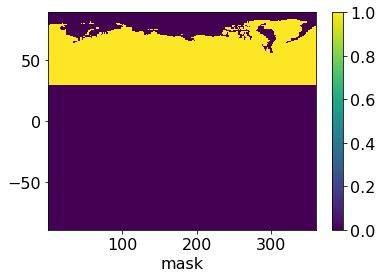

N_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- --

shape(reg_arcT) (744, 180, 360)
region T
shape(mask) (744, 180, 360)


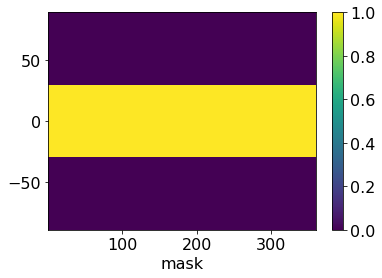

T
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (744, 180, 360)
region S
shape(mask) (744, 180, 360)


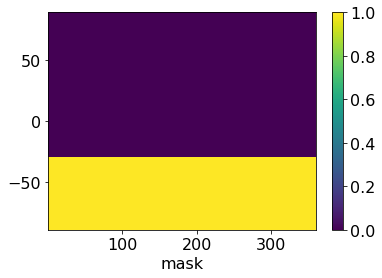

S
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (744, 180, 360)
region glo_noArc
shape(mask) (744, 180, 360)


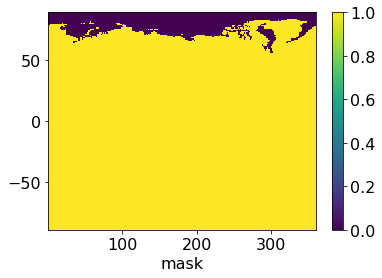

glo_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- 

shape(reg_arcT) (744, 180, 360)
region N_noArc
shape(mask) (744, 180, 360)


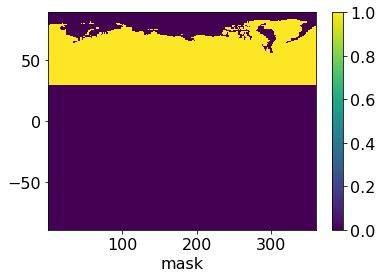

N_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- --

shape(reg_arcT) (744, 180, 360)
region T
shape(mask) (744, 180, 360)


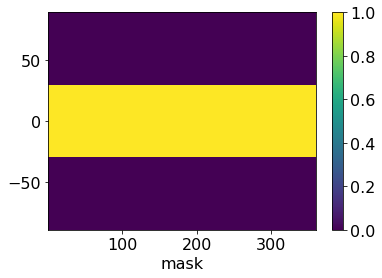

T
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (744, 180, 360)
region S
shape(mask) (744, 180, 360)


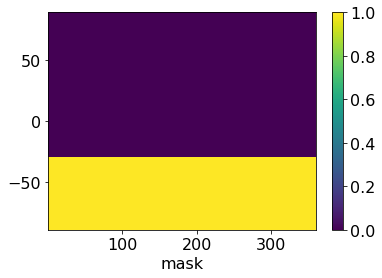

S
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (744, 180, 360)
region glo_noArc
shape(mask) (744, 180, 360)


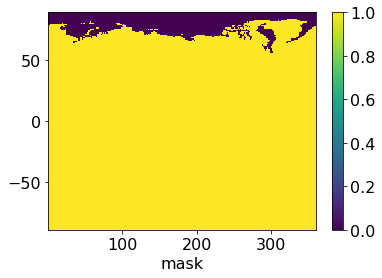

glo_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [1.151374355047994 0.4238304330779959 0.49058738570234095
 0.999794176906717 0.892355595790529 0.9213599359162353 1.0207664551256586
 0.8747441001804579 0.5363398829497007 1.2422128870196831
 1.4097082500522518 1.7065594631393497]
1 [1.1944898157266088 0.8756669630170621 0.9115738729374916
 1.1003538306487246 1.1279562037615003 1.4127893282020931
 1.2120956888264234 1.0270952625604148 0.7412756628724727
 1.2572544452126637 2.0800841971634894 2.0096002821047936]
2 [1.3782043786552627 0.8903415692646065 0.8422589297316239
 1.1683220304446351 1.393563403522892 1.3997199083637288
 1.4723193503768692 0.7750343747424903 0.9740641180288493
 1.1205965759933136 1.80438562050136 1.9588801853427285]
3 [1.291785441694708 0.8576470520792747 0.7643427085010742
 0.9810222161578445 1.1126908029542706 1.1985336354426603
 1.1354067750580228 0.8583350675215273 0.716909086929585
 1.3527763689231067 1.6914980548776735 1.80794

shape(reg_arcT) (744, 180, 360)
region N_noArc
shape(mask) (744, 180, 360)


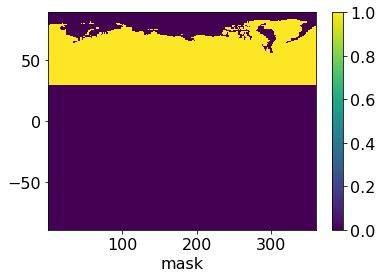

N_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [2.037491686422834 1.8748434529992444 1.7560299015299698 1.681322702856455
 1.1285141253707327 0.4248137961058209 -0.19011910598686446
 -0.532484721336212 -0.46390315383325764 0.22591904702124427
 0.9199509803034651 1.6487419649641917]
1 [1.972360769350871 1.9730896959640107 2.019523411065183 1.7229281736752329
 1.1304076626789028 0.579259427782868 -0.133710602248321
 -0.49130158700178744 -0.4144896560185127 0.33395802929735363
 1.2098543556933723 1.799770423007772]
2 [1.842990203798568 1.912098088082122 1.8181560127216183 1.6280893265438283
 1.2276106619806149 0.5459913914924239 -0.150109989700587
 -0.5540173647469319 -0.363699246834263 0.17261690285428943
 1.1144310660664654 1.758221874604951]
3 [1.9691103974477315 2.025528889192759 1.8933021407394335
 1.6634743683841324 1.2253052928168964 0.46084678894678405
 -0.21050184747861495 -0.515739739330275 -0.3635587969110002
 0.25073960877196366 1.0031561916424

shape(reg_arcT) (744, 180, 360)
region T
shape(mask) (744, 180, 360)


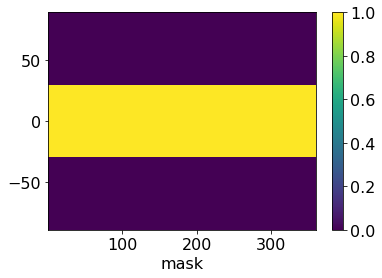

T
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.7046732325639345 -0.8925070462511698 -0.7900459601427068
 -0.8008072197360859 -0.9370219935397028 -0.8134484994951444
 -0.450407715497678 -0.31763009246708857 -0.4275227108883681
 -0.4964502007576983 -0.637868198423856 -0.5831958203274393]
1 [-0.6353603702497093 -0.5441100112447683 -0.6379285847245176
 -0.6975329856235886 -0.6629009808649337 -0.40180643269836175
 -0.26536627325717 -0.19769356388008677 -0.29759576392241993
 -0.5085941467883975 -0.4653111506662507 -0.5114181194252387]
2 [-0.4161376456661443 -0.45927892876116855 -0.509218538607639
 -0.5185127991285436 -0.6280195426675269 -0.42589562796885927
 -0.14390086123618223 -0.18994831637839057 -0.21120986293084007
 -0.4160323348521475 -0.5332654441412015 -0.45634735850531977]
3 [-0.4840022069666689 -0.5900094392157063 -0.6426754325334908
 -0.6059526273051975 -0.6505389133446272 -0.5659216119095241
 -0.2748190511311153 -0.22909161068876702 -0.4432727760375

shape(reg_arcT) (744, 180, 360)
region S
shape(mask) (744, 180, 360)


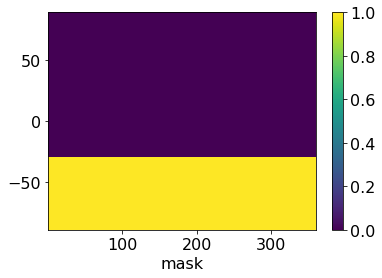

S
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.18144409881090498 -0.5585059736700794 -0.47539655568492234
 0.1192786937863482 0.7008634639594991 1.309994639305559
 1.6612932766102013 1.7248589139837587 1.427765747671326 1.512744040756137
 1.1276254681726425 0.6410133185025972]
1 [-0.14251058337455316 -0.5533127217021804 -0.4700209534031739
 0.07495864259708007 0.6604495219475313 1.235336333117587
 1.6111725643319144 1.7160904134422894 1.453361082813405
 1.4318905627037077 1.335540992136368 0.7212479785222607]
2 [-0.04864817947716072 -0.5624775900563473 -0.4666785443823559
 0.058745503029350436 0.7939722842098045 1.2796241448401642
 1.7663302013136384 1.519000055867813 1.5489732277939523
 1.3640120079911717 1.223219998576096 0.6570056692430978]
3 [-0.19332274878635447 -0.5778723978977772 -0.48628399970486846
 -0.07649952492109056 0.5379244234820015 1.3036084584054 1.620727673667753
 1.6031664175405693 1.5237406598781698 1.4935505268897058
 1.20861043107606

In [25]:
# integrate time-series:

#routine assumes flux is in mol/m2/s, this conversion is applied above, all should be correct.

roeden_glo_noArc= integrate_CO2flux(gasex_roeden,'glo_noArc',areaT,xax,yax)
roeden_N_noArc= integrate_CO2flux(gasex_roeden,'N_noArc',areaT,xax,yax)
roeden_T= integrate_CO2flux(gasex_roeden,'T',areaT,xax,yax)
roeden_S= integrate_CO2flux(gasex_roeden,'S',areaT,xax,yax)

# test with kw660
roeden_glo_noArc_660= integrate_CO2flux(gasex_roeden_660,'glo_noArc',areaT,xax,yax)
roeden_N_noArc_660= integrate_CO2flux(gasex_roeden_660,'N_noArc',areaT,xax,yax)
roeden_T_660= integrate_CO2flux(gasex_roeden_660,'T',areaT,xax,yax)
roeden_S_660= integrate_CO2flux(gasex_roeden_660,'S',areaT,xax,yax)

# SOCAT
roeden_A_glo_noArc= integrate_CO2flux(gasex_roeden_A,'glo_noArc',areaT,xax,yax)
roeden_A_N_noArc= integrate_CO2flux(gasex_roeden_A,'N_noArc',areaT,xax,yax)
roeden_A_T= integrate_CO2flux(gasex_roeden_A,'T',areaT,xax,yax)
roeden_A_S= integrate_CO2flux(gasex_roeden_A,'S',areaT,xax,yax)


land_glo_noArc= integrate_CO2flux(gasex_land,'glo_noArc',areaT,xax,yax)
land_N_noArc= integrate_CO2flux(gasex_land,'N_noArc',areaT,xax,yax)
land_T= integrate_CO2flux(gasex_land,'T',areaT,xax,yax)
land_S= integrate_CO2flux(gasex_land,'S',areaT,xax,yax)

#SOCAT
land_A_glo_noArc= integrate_CO2flux(gasex_land_A,'glo_noArc',areaT,xax,yax)
land_A_N_noArc= integrate_CO2flux(gasex_land_A,'N_noArc',areaT,xax,yax)
land_A_T= integrate_CO2flux(gasex_land_A,'T',areaT,xax,yax)
land_A_S= integrate_CO2flux(gasex_land_A,'S',areaT,xax,yax)


fesom_glo_noArc= integrate_CO2flux(gasex_fesom,'glo_noArc',areaT,xax,yax)
fesom_N_noArc= integrate_CO2flux(gasex_fesom,'N_noArc',areaT,xax,yax)
fesom_T= integrate_CO2flux(gasex_fesom,'T',areaT,xax,yax)
fesom_S= integrate_CO2flux(gasex_fesom,'S',areaT,xax,yax)

In [26]:
# replace emtpy values with NaN
land_glo_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_N_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_T[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan

land_A_glo_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_A_N_noArc[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_A_T[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_A_S[(gcb_years<1982) | (gcb_years>2018)]=np.nan

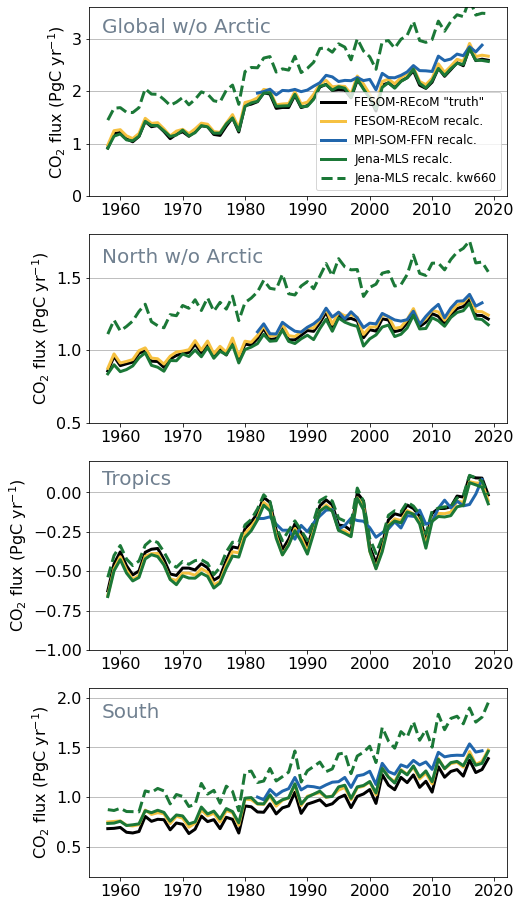

In [16]:
# this is only a check for kw660
# plot

# now plot both products together with the known truth:
truth_glo_noArc= np.load('fesom_fgco2_1x1_glonoArc_subsampling.npy')
truth_N_noArc= np.load('fesom_fgco2_1x1_NnoArc_subsampling.npy')
truth_T= np.load('fesom_fgco2_1x1_T_subsampling.npy')
truth_S= np.load('fesom_fgco2_1x1_S_subsampling.npy')


fig,ax = plt.subplots(4,1,figsize=(7.5,16))
#plt.figure(figsize=(8,8))


# global
ax1 = plt.subplot(4,1,1)
plt.plot(gcb_years,truth_glo_noArc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM "truth"')
plt.plot(gcb_years,fesom_glo_noArc,color='#F6C141',linestyle='solid',linewidth='3',label='FESOM-REcoM recalc.')
plt.plot(gcb_years,land_glo_noArc,color='#2166AC',linestyle='solid',linewidth='3',label='MPI-SOM-FFN recalc.')
plt.plot(gcb_years,roeden_glo_noArc,color='#1B7837',linestyle='solid',linewidth='3',label='Jena-MLS recalc.')
plt.plot(gcb_years,roeden_glo_noArc_660,color='#1B7837',linestyle='dashed',linewidth='3',label='Jena-MLS recalc. kw660')

plt.legend(loc='lower right')
plt.ylim(0,3.6) 

#plt.title('Global without Arctic')
plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.text(1957,3.1,'Global w/o Arctic',fontsize=20,color='slategrey')
plt.grid(b=None, which='major', axis='y')

# N-noArc
ax1 = plt.subplot(4,1,2)
plt.plot(gcb_years,truth_N_noArc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM "truth"')
plt.plot(gcb_years,fesom_N_noArc,color='#F6C141',linestyle='solid',linewidth='3',label='FESOM-REcoM')
plt.plot(gcb_years,land_N_noArc,color='#2166AC',linestyle='solid',linewidth='3',label='MPI-SOM-FFN')
plt.plot(gcb_years,roeden_N_noArc,color='#1B7837',linestyle='solid',linewidth='3',label='Jena-MLS')
plt.plot(gcb_years,roeden_N_noArc_660,color='#1B7837',linestyle='dashed',linewidth='3',label='Jena-MLS recalc. kw660')

#plt.legend()
#plt.title('North (no Arctic)')
plt.text(1957,1.6,'North w/o Arctic',fontsize=20,color='slategrey')
plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0.5,1.8) 
plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,1,3)
plt.plot(gcb_years,truth_T,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM "truth"')
plt.plot(gcb_years,fesom_T,color='#F6C141',linestyle='solid',linewidth='3',label='FESOM-REcoM')
plt.plot(gcb_years,land_T,color='#2166AC',linestyle='solid',linewidth='3',label='MPI-SOM-FFN')
plt.plot(gcb_years,roeden_T,color='#1B7837',linestyle='solid',linewidth='3',label='Jena-MLS')
plt.plot(gcb_years,roeden_T_660,color='#1B7837',linestyle='dashed',linewidth='3',label='Jena-MLS recalc. kw660')


#plt.legend()
#plt.title('Tropics')
plt.text(1957,0.05,'Tropics',fontsize=20,color='slategrey')
plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(-1.0,0.2) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,1,4)
plt.plot(gcb_years,truth_S,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM "truth"')

plt.plot(gcb_years,fesom_S,color='#F6C141',linestyle='solid',linewidth='3',label='FESOM-REcoM recalc.')
plt.plot(gcb_years,land_S,color='#2166AC',linestyle='solid',linewidth='3',label='MPI-SOM-FFN')
plt.plot(gcb_years,roeden_S,color='#1B7837',linestyle='solid',linewidth='3',label='Jena-MLS')
plt.plot(gcb_years,roeden_S_660,color='#1B7837',linestyle='dashed',linewidth='3',label='Jena-MLS recalc. kw660')

#plt.title('South')
plt.text(1957,1.8,'South',fontsize=20,color='slategrey')
plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0.2,2.1) 
plt.grid(b=None, which='major', axis='y')



plt.savefig('subsampling_recalcgasex_w660.png',dpi=300,facecolor='w',transparent=False)
plt.show()

In [37]:
# calculate differences, 2009-2018
print('for bgcArgo:')
print('MPI-SOM-FFN)')
print('land_glo_noArc-fesom_glo_noArc: ',np.nanmean(land_glo_noArc[ind]-fesom_glo_noArc[ind]))
print('in percent: ',np.nanmean(land_glo_noArc[ind]-fesom_glo_noArc[ind])/np.nanmean(fesom_glo_noArc[ind])*100,'%')
print('land_N_noArc-fesom_N_noArc: ',np.nanmean(land_N_noArc[ind]-fesom_N_noArc[ind]))
print('in percent: ',np.nanmean(land_N_noArc[ind]-fesom_N_noArc[ind])/np.nanmean(fesom_N_noArc[ind])*100,'%')
print('land_T-fesom_T: ',np.nanmean(land_T[ind]-fesom_T[ind]))
print('in percent: ',np.nanmean(land_T[ind]-fesom_T[ind])/np.nanmean(fesom_T[ind])*100,'%')
print('land_S-fesom_S: ',np.nanmean(land_S[ind]-fesom_S[ind]))
print('in percent: ',np.nanmean(land_S[ind]-fesom_S[ind])/np.nanmean(fesom_S[ind])*100,'%')

print('CarboScope)')
print('roeden_glo_noArc-fesom_glo_noArc: ',np.nanmean(roeden_glo_noArc[ind]-fesom_glo_noArc[ind]))
print('in percent: ',np.nanmean(roeden_glo_noArc[ind]-fesom_glo_noArc[ind])/np.nanmean(fesom_glo_noArc[ind])*100,'%')
print('roeden_N_noArc-fesom_N_noArc: ',np.nanmean(roeden_N_noArc[ind]-fesom_N_noArc[ind]))
print('in percent: ',np.nanmean(roeden_N_noArc[ind]-fesom_N_noArc[ind])/np.nanmean(fesom_N_noArc[ind])*100,'%')
print('roeden_T-fesom_T: ',np.nanmean(roeden_T[ind]-fesom_T[ind]))
print('in percent: ',np.nanmean(roeden_T[ind]-fesom_T[ind])/np.nanmean(fesom_T[ind])*100,'%')
print('roeden_S-fesom_S: ',np.nanmean(roeden_S[ind]-fesom_S[ind]))
print('in percent: ',np.nanmean(roeden_S[ind]-fesom_S[ind])/np.nanmean(fesom_S[ind])   *100,'%')
      
      
print('for SOCAT:')
print('MPI-SOM-FFN)')
print('land_glo_noArc-fesom_glo_noArc: ',np.nanmean(land_A_glo_noArc[ind]-fesom_glo_noArc[ind]))
print('in percent: ',np.nanmean(land_A_glo_noArc[ind]-fesom_glo_noArc[ind])/np.nanmean(fesom_glo_noArc[ind])*100,'%')
print('land_N_noArc-fesom_N_noArc: ',np.nanmean(land_A_N_noArc[ind]-fesom_N_noArc[ind]))
print('in percent: ',np.nanmean(land_A_N_noArc[ind]-fesom_N_noArc[ind])/np.nanmean(fesom_N_noArc[ind])*100,'%')
print('land_T-fesom_T: ',np.nanmean(land_A_T[ind]-fesom_T[ind]))
print('in percent: ',np.nanmean(land_A_T[ind]-fesom_T[ind])/np.nanmean(fesom_T[ind])*100,'%')
print('land_S-fesom_S: ',np.nanmean(land_A_S[ind]-fesom_S[ind]))
print('in percent: ',np.nanmean(land_A_S[ind]-fesom_S[ind])/np.nanmean(fesom_S[ind])*100,'%')

print('CarboScope)')
print('roeden_glo_noArc-fesom_glo_noArc: ',np.nanmean(roeden_A_glo_noArc[ind]-fesom_glo_noArc[ind]))
print('in percent: ',np.nanmean(roeden_A_glo_noArc[ind]-fesom_glo_noArc[ind])/np.nanmean(fesom_glo_noArc[ind])*100,'%')
print('roeden_N_noArc-fesom_N_noArc: ',np.nanmean(roeden_A_N_noArc[ind]-fesom_N_noArc[ind]))
print('in percent: ',np.nanmean(roeden_A_N_noArc[ind]-fesom_N_noArc[ind])/np.nanmean(fesom_N_noArc[ind])*100,'%')
print('roeden_T-fesom_T: ',np.nanmean(roeden_A_T[ind]-fesom_T[ind]))
print('in percent: ',np.nanmean(roeden_A_T[ind]-fesom_T[ind])/np.nanmean(fesom_T[ind])*100,'%')
print('roeden_S-fesom_S: ',np.nanmean(roeden_A_S[ind]-fesom_S[ind]))
print('in percent: ',np.nanmean(roeden_A_S[ind]-fesom_S[ind])/np.nanmean(fesom_S[ind])  *100,'%') 
      
      
# print('fesom_glo_noArc-roeden_glo_noArc: ',np.nanmean(fesom_glo_noArc[ind]-roeden_glo_noArc[ind]))
# print('in percent: ',np.nanmean(fesom_glo_noArc[ind]-roeden_glo_noArc[ind])/np.nanmean(fesom_glo_noArc[ind])

# print('fesom_N_noArc-land_N_noArc: ',np.nanmean(fesom_N_noArc[ind]-land_N_noArc[ind]))
# print('fesom_N_noArc-roeden_N_noArc: ',np.nanmean(fesom_N_noArc[ind]-roeden_N_noArc[ind]))

# print('fesom_T-land_T: ',np.nanmean(fesom_T[ind]-land_T[ind]))
# print('fesom_T-roeden_T: ',np.nanmean(fesom_T[ind]-roeden_T[ind]))

# print('fesom_S-land_S: ',np.nanmean(fesom_S[ind]-land_S[ind]))
# print('fesom_S-roeden_S: ',np.nanmean(fesom_S[ind]-roeden_S[ind]))

print('-------kw-------')
print('roeden_noArc_660-roeden_glo_noArc: ',np.nanmean(roeden_glo_noArc_660-roeden_glo_noArc))
print('roeden_N_noArc_660-roeden_N_noArc: ',np.nanmean(roeden_N_noArc_660-roeden_N_noArc))
print('roeden_T_660-roeden_T: ',np.nanmean(roeden_T_660-roeden_T))
print('roeden_S_660-roeden_S: ',np.nanmean(roeden_S_660-roeden_S))


for bgcArgo:
MPI-SOM-FFN)
land_glo_noArc-fesom_glo_noArc:  0.13218078025938365
in percent:  5.259784461114472 %
land_N_noArc-fesom_N_noArc:  0.026170388484289032
in percent:  2.049033965583693 %
land_T-fesom_T:  0.0044852258087628985
in percent:  -5.399654994897876 %
land_S-fesom_S:  0.10152516596633157
in percent:  7.697689362282617 %
CarboScope)
roeden_glo_noArc-fesom_glo_noArc:  -0.07099882654301277
in percent:  -2.8252104721691524 %
roeden_N_noArc-fesom_N_noArc:  -0.05194731032220645
in percent:  -4.067261108287255 %
roeden_T-fesom_T:  -0.019878155576284168
in percent:  23.93083127211487 %
roeden_S-fesom_S:  0.0008266393554775542
in percent:  0.06267621345444477 %
for SOCAT:
MPI-SOM-FFN)
land_glo_noArc-fesom_glo_noArc:  0.199487773559787
in percent:  7.938088196279971 %
land_N_noArc-fesom_N_noArc:  0.08989175001319846
in percent:  7.0381549403967885 %
land_T-fesom_T:  -0.11363839997448646
in percent:  136.80652439741536 %
land_S-fesom_S:  0.2232344235210749
in percent:  16.92574674

In [38]:
# differences to known truth
print('truth_glo_noArc-fesom_glo_noArc: ',np.nanmean(truth_glo_noArc[ind]-fesom_glo_noArc[ind]))
print('truth_S-fesom_S: ',np.nanmean(truth_S[ind]-fesom_S[ind]))

print('truth_glo_noArc-land_glo_noArc: ',np.nanmean(truth_glo_noArc[ind]-land_glo_noArc[ind]))
print('truth_glo_noArc-roeden_glo_noArc: ',np.nanmean(truth_glo_noArc[ind]-roeden_glo_noArc[ind]))

print('truth_N_noArc-land_N_noArc: ',np.nanmean(truth_N_noArc[ind]-land_N_noArc[ind]))
print('truth_N_noArc-roeden_N_noArc: ',np.nanmean(truth_N_noArc[ind]-roeden_N_noArc[ind]))

print('truth_T-land_T: ',np.nanmean(truth_T[ind]-land_T[ind]))
print('truth_T-roeden_T: ',np.nanmean(truth_T[ind]-roeden_T[ind]))

print('truth_S-land_S: ',np.nanmean(truth_S[ind]-land_S[ind]))
print('truth_S-roeden_S: ',np.nanmean(truth_S[ind]-roeden_S[ind]))

truth_glo_noArc-fesom_glo_noArc:  -0.07451746653324309
truth_S-fesom_S:  -0.08254910348897415
truth_glo_noArc-land_glo_noArc:  -0.20669824679262674
truth_glo_noArc-roeden_glo_noArc:  -0.003518639990230321
truth_N_noArc-land_N_noArc:  -0.05122762852547495
truth_N_noArc-roeden_N_noArc:  0.02689007028102053
truth_T-land_T:  0.028603651188153834
truth_T-roeden_T:  0.052967032573200915
truth_S-land_S:  -0.18407426945530572
truth_S-roeden_S:  -0.0833757428444517


In [11]:
# scale kwco2 and recalculate gas-ex

# kwco2 now includes Schmidt number
gasex_fesom_165 = kwco2*16.5/15.5 * alpha * rhosw * (spco2_fesom - pco2atm) *conv_molm2s

# roeden
gasex_roeden_165 = kwco2*16.5/15.5 * alpha * rhosw * (roeden_spco2_1x1_C - pco2atm) *conv_molm2s

# land
gasex_land_165 = kwco2*16.5/15.5 * alpha * rhosw * (land_spco2_1x1_C - pco2atm) *conv_molm2s


/work/ollie/jhauck/gcp2018/py_recom/GCB/code/2021/subsampling/integrate_CO2flux.py:27: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad('white',1.)


shape(reg_arcT) (744, 180, 360)
region glo_noArc
shape(mask) (744, 180, 360)


/work/ollie/jhauck/gcp2018/py_recom/GCB/code/2021/subsampling/integrate_CO2flux.py:116: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(reg_lon,reg_lat,np.squeeze(mask[1,:,:]))#, vmin=-60, vmax=750)


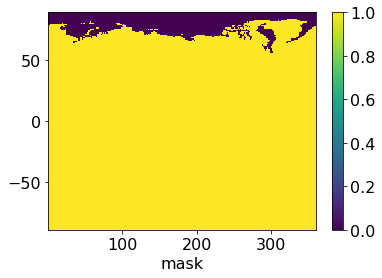

glo_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [1.155097210017761 0.5312423756911735 0.6143480125052612
 0.9750148082981092 0.7586491975019422 0.8528466781937247
 0.9854769936614227 1.0173928675460986 0.7368546077419672
 1.2491819419338337 1.2355741432451637 1.553257940634717]
1 [1.1268027916951544 0.8905437029064333 1.0244987000333503
 0.9999885430802936 0.9739706119088897 1.301496296883365
 1.2234707261059885 1.1270216274896376 0.9469140696812056
 1.290170640020742 1.8968710285471697 1.785681668464881]
2 [1.4073663054539263 0.9445865935287993 0.9240676311265825
 1.1760507039276584 1.2625184517210568 1.3241896010975622
 1.5308288611755476 0.8623077562356443 1.154607040933936
 1.1368466872305873 1.632107192207531 1.7707482965870252]
3 [1.2770590682967822 1.0139918852417675 0.873273853844691
 0.9602979240388386 0.9724774813058289 1.1089907058489272
 1.1531744418601415 0.9768891390193217 0.7908364271724235
 1.3924610108459954 1.4834290261803436 1.675365

shape(reg_arcT) (744, 180, 360)
region N_noArc
shape(mask) (744, 180, 360)


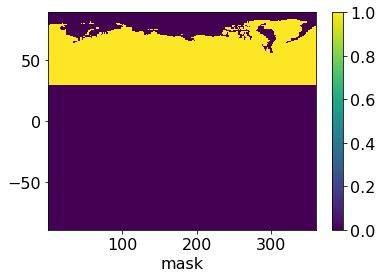

N_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [2.090188894784998 1.9630046973939157 1.8976098739297371
 1.7334895933724357 1.0497077321766048 0.3635949859886178
 -0.16837628816607433 -0.4736516431622918 -0.42272531113113443
 0.17756568869080977 0.8780031381843989 1.6179464824548728]
1 [1.9580357568963682 2.0226221576293693 2.1428064888059564
 1.7136788816631212 1.022400279864787 0.49964434137810954
 -0.14218779060412678 -0.43805731576147316 -0.38359799134142214
 0.2681009136000949 1.1179406927777151 1.719651065033458]
2 [1.8749679421663772 1.9712052253523906 1.9063073663271695
 1.6700318411680923 1.1364953971134129 0.48313074995605576
 -0.13239093511264985 -0.4983469221911642 -0.33278016557027285
 0.09983150052585882 1.004512337387895 1.7146714784378527]
3 [2.0036558600175054 2.1414051671880374 2.0311811990009185
 1.6852245642616577 1.1119420296180273 0.39551538837866107
 -0.2154049934756066 -0.46052495624978157 -0.37057827429449935
 0.196817133492216 

shape(reg_arcT) (744, 180, 360)
region T
shape(mask) (744, 180, 360)


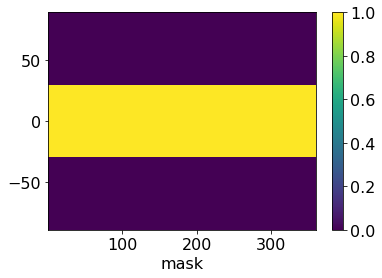

T
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.746064429332462 -0.9437925082703716 -0.8380907977390377
 -0.853496361339277 -1.0019706195603015 -0.8547429538174152
 -0.5052663258802507 -0.3292769011540639 -0.47635263603743166
 -0.5492106448721005 -0.7180757801426613 -0.6303286814345626]
1 [-0.7109903612444145 -0.6209238049107578 -0.6829823627051749
 -0.7575485374316147 -0.6964243197837062 -0.4239998495222031
 -0.28386891370640793 -0.2271019847248223 -0.3197501270489705
 -0.5452385232583584 -0.5132401542544156 -0.5804832570987087]
2 [-0.4604799250295762 -0.5341670637956422 -0.5327472794115758
 -0.5695356455300469 -0.676636299357887 -0.5039145400758457
 -0.17220072977942716 -0.22879355447440392 -0.23653423609458404
 -0.4493234765644269 -0.5866319626047661 -0.5043848578951086]
3 [-0.5506941378610195 -0.6411966696920126 -0.6790725452446104
 -0.6542566466098146 -0.7034484651656379 -0.6221017440905926
 -0.31164934620811374 -0.25952076063190666 -0.502837710619968

shape(reg_arcT) (744, 180, 360)
region S
shape(mask) (744, 180, 360)


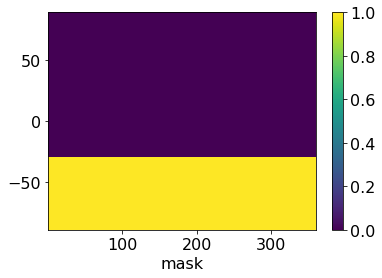

S
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.18902725543477492 -0.4879698134323707 -0.44517106368543846
 0.09502157626495067 0.7109120848856388 1.343994646022522
 1.6591196077077477 1.820321411862454 1.635932554910533 1.6208268981151241
 1.0756467852034264 0.5656401396144066]
1 [-0.12024260395679924 -0.5111546498121781 -0.4353254260674313
 0.04385819884878713 0.6479946518278089 1.2258518050274587
 1.649527430416523 1.7921809279759329 1.6502621880715982
 1.5673082496790054 1.29217049002387 0.6465138605301317]
2 [-0.007121711682874388 -0.49245156802794904 -0.4494924557890107
 0.07555450828961305 0.8026593539655312 1.344973391217352
 1.8354205260676246 1.5894482329012125 1.7239214425987928
 1.4863386632691555 1.2142268174244024 0.5604616760442813]
3 [-0.17590265385970338 -0.48621661225425733 -0.4788347999116169
 -0.0706699936130045 0.5639839168534391 1.3355770615608586
 1.680228781543862 1.69693485590101 1.6642524120868913 1.6285991614939952
 1.15395137333

shape(reg_arcT) (744, 180, 360)
region glo_noArc
shape(mask) (744, 180, 360)


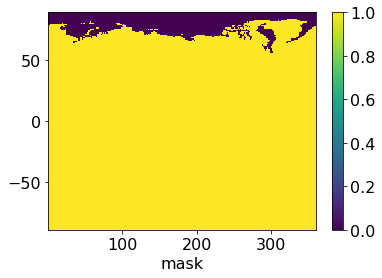

glo_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- 

shape(reg_arcT) (744, 180, 360)
region N_noArc
shape(mask) (744, 180, 360)


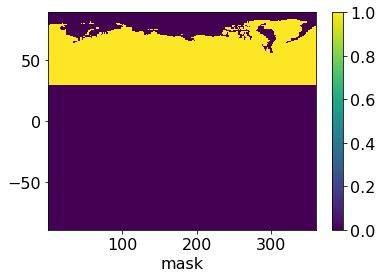

N_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- --

shape(reg_arcT) (744, 180, 360)
region T
shape(mask) (744, 180, 360)


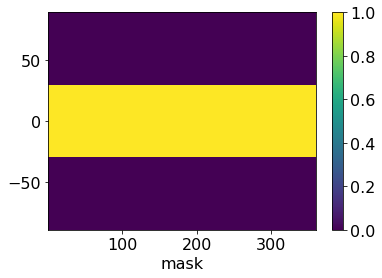

T
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (744, 180, 360)
region S
shape(mask) (744, 180, 360)


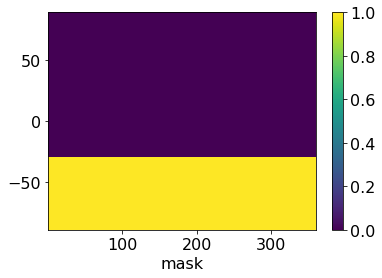

S
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-- -- -- -- -- -- -- -- -- -- -- --]
1 [-- -- -- -- -- -- -- -- -- -- -- --]
2 [-- -- -- -- -- -- -- -- -- -- -- --]
3 [-- -- -- -- -- -- -- -- -- -- -- --]
4 [-- -- -- -- -- -- -- -- -- -- -- --]
5 [-- -- -- -- -- -- -- -- -- -- -- --]
6 [-- -- -- -- -- -- -- -- -- -- -- --]
7 [-- -- -- -- -- -- -- -- -- -- -- --]
8 [-- -- -- -- -- -- -- -- -- -- -- --]
9 [-- -- -- -- -- -- -- -- -- -- -- --]
10 [-- -- -- -- -- -- -- -- -- -- -- --]
11 [-- -- -- -- -- -- -- -- -- -- -- --]
12 [-- -- -- -- -- -- -- -- -- -- -- --]
13 [-- -- -- -- -- -- -- -- -- -- -- --]
14 [-- -- -- -- -- -- -- -- -- -- -- --]
15 [-- -- -- -- -- -- -- -- -- -- -- --]
16 [-- -- -- -- -- -- -- -- -- -- -- --]
17 [-- -- -- -- -- -- -- -- -- -- -- --]
18 [-- -- -- -- -- -- -- -- -- -- -- --]
19 [-- -- -- -- -- -- -- -- -- -- -- --]
20 [-- -- -- -- -- -- -- -- -- -- -- --]
21 [-- -- -- -- -- -- -- -- -- -- -- --]
22 [-- -- -- -- -- -- -- -- -- -- --

shape(reg_arcT) (744, 180, 360)
region glo_noArc
shape(mask) (744, 180, 360)


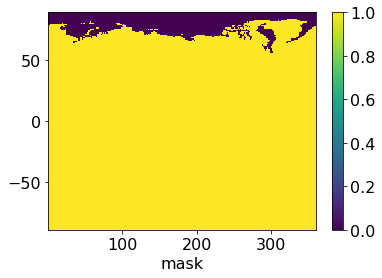

glo_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [1.2256565715027032 0.4511743319862534 0.5222381847799111
 1.064297027029731 0.9499269245512085 0.9808025124269601
 1.0866223554563468 0.9311792034179072 0.5709424560432292
 1.322355653924179 1.5006571694104613 1.816660073664469]
1 [1.2715536748057445 0.9321616057923561 0.9703850905463621
 1.1713444003679967 1.2007275717461137 1.5039370267957766
 1.2902954106861926 1.0933594730481835 0.7890998991868254
 1.3383676352263842 2.21428317762565 2.139251913208329]
2 [1.4671207901814087 0.9477829608300649 0.8965982155207609
 1.2436976453120312 1.4834707198792076 1.4900244185807439
 1.5673076955624734 0.8250365924678125 1.0369069643532913
 1.1928931292832046 1.9207975960175767 2.0852595521390334]
3 [1.3751264379330763 0.9129791199553576 0.8136551413075948
 1.0443139720389953 1.1844773063706753 1.2758583861163804
 1.2086588250617665 0.9137115234906577 0.7631612860863328
 1.4400522636923394 1.800626961643975 1.92458

shape(reg_arcT) (744, 180, 360)
region N_noArc
shape(mask) (744, 180, 360)


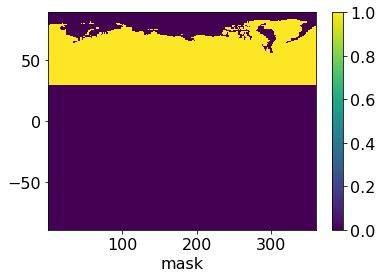

N_noArc
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [2.1689427629662426 1.9958010951282281 1.8693221532415805
 1.7897951352988066 1.2013214882978769 0.4522211377900674
 -0.20238485476021054 -0.5668385743256451 -0.4938323895644354
 0.2404944694097116 0.9793026564520759 1.75511241431672]
1 [2.0996098512444754 2.100385805381044 2.1498152440371308 1.834084830041377
 1.2033371893033482 0.6166310037688593 -0.14233709271595454
 -0.522998463582548 -0.44123092414873927 0.35550370860686037
 1.287909475415525 1.915884643846983]
2 [1.961892797592024 2.0354592550551627 1.9354564006391421
 1.7331273476111724 1.3068113498503318 0.5812166425564512
 -0.159794505165141 -0.5897604205370566 -0.38716371437195735
 0.18375347723198557 1.1863298445223665 1.8716555439343023]
3 [2.0961497779282303 2.1562081723664854 2.0154506659484284
 1.770795295376657 1.30435724719218 0.4905788398465765
 -0.22408261183207398 -0.5490132708999701 -0.3870142031633228
 0.2669163577249936 1.067875945941

shape(reg_arcT) (744, 180, 360)
region T
shape(mask) (744, 180, 360)


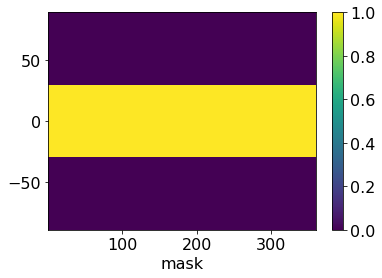

T
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.7501360217616077 -0.9500881460093097 -0.8410166672486877
 -0.8524722016545431 -0.997475025380974 -0.8659290478496698
 -0.4794662777878508 -0.33812235649722333 -0.45510482126826257
 -0.5284792459678723 -0.6790209854189436 -0.620821357122758]
1 [-0.6763513618787228 -0.5792138829379792 -0.6790852676099705
 -0.7425351137283364 -0.7056687860820261 -0.4277294283563205
 -0.282486677983439 -0.21044798735622144 -0.31679549062709217
 -0.541406672387649 -0.4953312249027829 -0.5444128368075122]
2 [-0.4429852357091213 -0.48890982739092137 -0.5420713475500673
 -0.551965237781998 -0.6685369325170448 -0.45337276525717274
 -0.1531847877675489 -0.20220304646731907 -0.22483630570057184
 -0.44287313064906025 -0.5676696663438596 -0.4857891235701793]
3 [-0.515228155803228 -0.6280745643263971 -0.6841383636646838
 -0.6450463451958554 -0.6925091658184741 -0.6024326836456223
 -0.292549312494413 -0.24387171460417126 -0.4718710196529126

shape(reg_arcT) (744, 180, 360)
region S
shape(mask) (744, 180, 360)


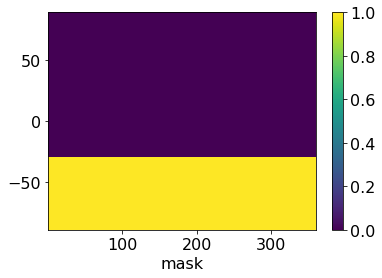

S
(744, 180, 360)
(744, 180, 360)
(744, 180, 360)
True
False
True
False
0 [-0.1931501697019311 -0.5945386171326652 -0.5060673012129818
 0.12697409338546742 0.7460804616343054 1.3945104224865625
 1.7684734880044077 1.8361401342407753 1.5198796668759276
 1.6103404304823397 1.2003754983773292 0.6823690164705067]
1 [-0.15170481456000826 -0.589010316650708 -0.500344885880798
 0.07979468405495621 0.7030591685247913 1.3150354513832379
 1.7151191813855862 1.8268059239869534 1.5471263139626568
 1.5242705990071728 1.4217049271129076 0.7677801061688583]
2 [-0.051786771701493664 -0.5987664668341762 -0.4967868375683144
 0.06253553548285691 0.8451963025459208 1.3621805412814652
 1.8802869884951632 1.6170000594721883 1.6489069844258204
 1.4520127827002796 1.3021374178390703 0.6993931317749105]
3 [-0.20579518419192572 -0.6151544880847305 -0.5176571609761502
 -0.08143497814180609 0.5726292249969693 1.3877122299154259
 1.7252907493882532 1.7065965089947992 1.622046508902568
 1.5899086253987191 1.2865852

In [12]:
# integrate time-series:

#routine assumes flux is in mol/m2/s, this conversion is applied above, all should be correct.

roeden_glo_noArc_165= integrate_CO2flux(gasex_roeden_165,'glo_noArc',areaT,xax,yax)
roeden_N_noArc_165= integrate_CO2flux(gasex_roeden_165,'N_noArc',areaT,xax,yax)
roeden_T_165= integrate_CO2flux(gasex_roeden_165,'T',areaT,xax,yax)
roeden_S_165= integrate_CO2flux(gasex_roeden_165,'S',areaT,xax,yax)


land_glo_noArc_165= integrate_CO2flux(gasex_land_165,'glo_noArc',areaT,xax,yax)
land_N_noArc_165= integrate_CO2flux(gasex_land_165,'N_noArc',areaT,xax,yax)
land_T_165= integrate_CO2flux(gasex_land_165,'T',areaT,xax,yax)
land_S_165= integrate_CO2flux(gasex_land_165,'S',areaT,xax,yax)


fesom_glo_noArc_165= integrate_CO2flux(gasex_fesom_165,'glo_noArc',areaT,xax,yax)
fesom_N_noArc_165= integrate_CO2flux(gasex_fesom_165,'N_noArc',areaT,xax,yax)
fesom_T_165= integrate_CO2flux(gasex_fesom_165,'T',areaT,xax,yax)
fesom_S_165= integrate_CO2flux(gasex_fesom_165,'S',areaT,xax,yax)

In [13]:
# replace emtpy values with NaN
land_glo_noArc_165[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_N_noArc_165[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_T_165[(gcb_years<1982) | (gcb_years>2018)]=np.nan
land_S_165[(gcb_years<1982) | (gcb_years>2018)]=np.nan

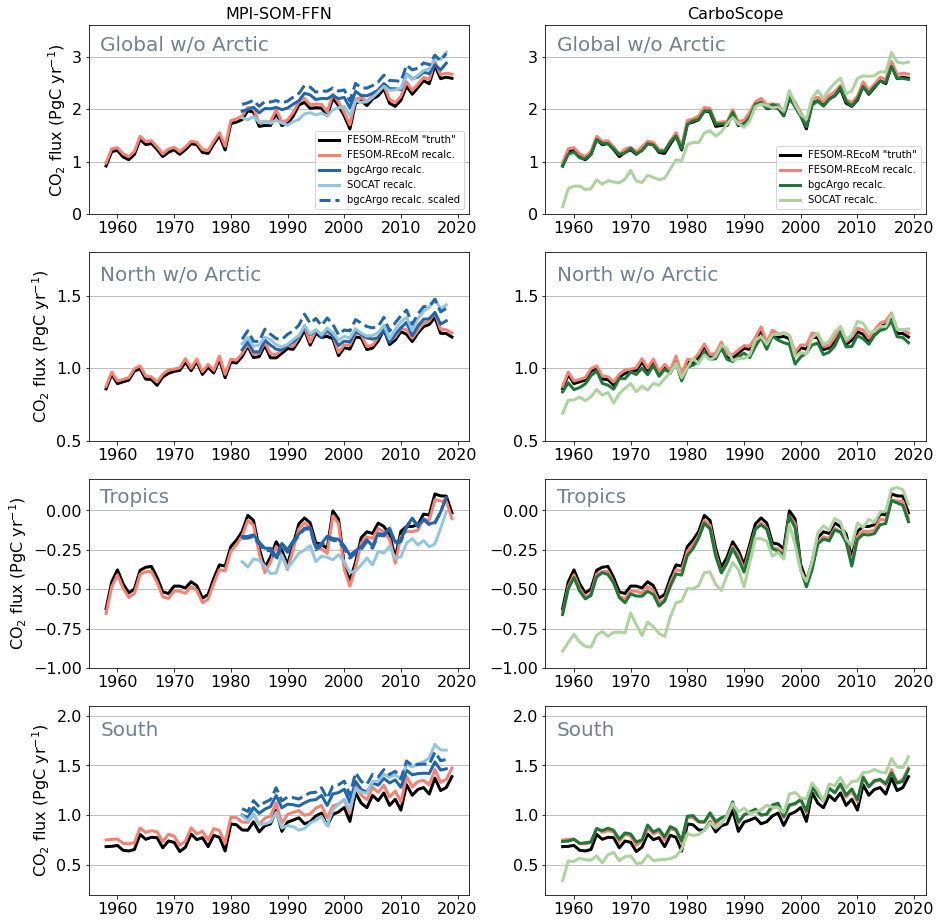

In [40]:
# plot

# now plot both products together with the known truth:
truth_glo_noArc= np.load('fesom_fgco2_1x1_glonoArc_subsampling.npy')
truth_N_noArc= np.load('fesom_fgco2_1x1_NnoArc_subsampling.npy')
truth_T= np.load('fesom_fgco2_1x1_T_subsampling.npy')
truth_S= np.load('fesom_fgco2_1x1_S_subsampling.npy')


fig,ax = plt.subplots(4,2,figsize=(15,16))
#plt.figure(figsize=(8,8))


# global
ax1 = plt.subplot(4,2,1)
plt.plot(gcb_years,truth_glo_noArc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM "truth"')
plt.plot(gcb_years,fesom_glo_noArc,color='salmon',linestyle='solid',linewidth='3',label='FESOM-REcoM recalc.')
plt.plot(gcb_years,land_glo_noArc,color='#2166AC',linestyle='solid',linewidth='3',label='bgcArgo recalc.')
#plt.plot(gcb_years,roeden_glo_noArc,color='#1B7837',linestyle='solid',linewidth='3',label='CarboScope recalc.')
plt.plot(gcb_years,land_A_glo_noArc,color='#92C5DE',linestyle='solid',linewidth='3',label='SOCAT recalc.')

#plt.plot(gcb_years,fesom_glo_noArc_165,color='salmon',linestyle='dashed',linewidth='3',label='FESOM-REcoM recalc. scaled')
plt.plot(gcb_years,land_glo_noArc_165,color='#2166AC',linestyle='dashed',linewidth='3',label='bgcArgo recalc. scaled')
# plt.plot(gcb_years,roeden_glo_noArc_165,color='#1B7837',linestyle='dashed',linewidth='3',label='Jena-MLS recalc. scaled')

plt.legend(loc='lower right',fontsize=10)
plt.ylim(0,3.6) 
plt.title('MPI-SOM-FFN', fontsize=16)#Global without Arctic')
plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.text(1957,3.1,'Global w/o Arctic',fontsize=20,color='slategrey')
plt.grid(b=None, which='major', axis='y')

# N-noArc
ax1 = plt.subplot(4,2,3)
plt.plot(gcb_years,truth_N_noArc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM "truth"')
plt.plot(gcb_years,fesom_N_noArc,color='salmon',linestyle='solid',linewidth='3',label='FESOM-REcoM')
plt.plot(gcb_years,land_N_noArc,color='#2166AC',linestyle='solid',linewidth='3',label='MPI-SOM-FFN')
#plt.plot(gcb_years,roeden_N_noArc,color='#1B7837',linestyle='solid',linewidth='3',label='Jena-MLS')
plt.plot(gcb_years,land_A_N_noArc,color='#92C5DE',linestyle='solid',linewidth='3',label='SOCAT recalc.')

#plt.plot(gcb_years,fesom_N_noArc_165,color='salmon',linestyle='dashed',linewidth='3',label='FESOM-REcoM recalc. scaled')
plt.plot(gcb_years,land_N_noArc_165,color='#2166AC',linestyle='dashed',linewidth='3',label='MPI-SOM-FFN recalc. scaled')
# plt.plot(gcb_years,roeden_N_noArc_165,color='#1B7837',linestyle='dashed',linewidth='3',label='Jena-MLS recalc. scaled')

#plt.legend()
plt.text(1957,1.6,'North w/o Arctic',fontsize=20,color='slategrey')
plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0.5,1.8) 
plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,2,5)
plt.plot(gcb_years,truth_T,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM "truth"')
plt.plot(gcb_years,fesom_T,color='salmon',linestyle='solid',linewidth='3',label='FESOM-REcoM')
plt.plot(gcb_years,land_T,color='#2166AC',linestyle='solid',linewidth='3',label='MPI-SOM-FFN')
#plt.plot(gcb_years,roeden_T,color='#1B7837',linestyle='solid',linewidth='3',label='Jena-MLS')
plt.plot(gcb_years,land_A_T,color='#92C5DE',linestyle='solid',linewidth='3',label='SOCAT recalc.')


#plt.plot(gcb_years,fesom_T_165,color='salmon',linestyle='dashed',linewidth='3',label='FESOM-REcoM recalc. scaled')
plt.plot(gcb_years,land_T_165,color='#2166AC',linestyle='dashed',linewidth='3',label='MPI-SOM-FFN recalc. scaled')
# plt.plot(gcb_years,roeden_T_165,color='#1B7837',linestyle='dashed',linewidth='3',label='Jena-MLS recalc. scaled')
#plt.legend()
plt.text(1957,0.05,'Tropics',fontsize=20,color='slategrey')
plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(-1.0,0.2) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,2,7)
plt.plot(gcb_years,truth_S,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM "truth"')

plt.plot(gcb_years,fesom_S,color='salmon',linestyle='solid',linewidth='3',label='FESOM-REcoM recalc.')
plt.plot(gcb_years,land_S,color='#2166AC',linestyle='solid',linewidth='3',label='MPI-SOM-FFN')
#plt.plot(gcb_years,roeden_S,color='#1B7837',linestyle='solid',linewidth='3',label='Jena-MLS')
plt.plot(gcb_years,land_A_S,color='#92C5DE',linestyle='solid',linewidth='3',label='SOCAT recalc.')


#plt.plot(gcb_years,fesom_S_165,color='salmon',linestyle='dashed',linewidth='3',label='FESOM-REcoM recalc. scaled')
plt.plot(gcb_years,land_S_165,color='#2166AC',linestyle='dashed',linewidth='3',label='MPI-SOM-FFN recalc. scaled')
# plt.plot(gcb_years,roeden_S_165,color='#1B7837',linestyle='dashed',linewidth='3',label='Jena-MLS recalc. scaled')

plt.text(1957,1.8,'South',fontsize=20,color='slategrey')
plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0.2,2.1) 
plt.grid(b=None, which='major', axis='y')

#-------------------------------------------------
# Rödenbeck
ax1 = plt.subplot(4,2,2)
plt.plot(gcb_years,truth_glo_noArc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM "truth"')
plt.plot(gcb_years,fesom_glo_noArc,color='salmon',linestyle='solid',linewidth='3',label='FESOM-REcoM recalc.')
#plt.plot(gcb_years,land_glo_noArc,color='#2166AC',linestyle='solid',linewidth='3',label='bgcArgo recalc.')
plt.plot(gcb_years,roeden_glo_noArc,color='#1B7837',linestyle='solid',linewidth='3',label='bgcArgo recalc.')
plt.plot(gcb_years,roeden_A_glo_noArc,color='#ACD39E',linestyle='solid',linewidth='3',label='SOCAT recalc.')

#plt.plot(gcb_years,fesom_glo_noArc_165,color='salmon',linestyle='dashed',linewidth='3',label='FESOM-REcoM recalc. scaled')
#plt.plot(gcb_years,land_glo_noArc_165,color='#2166AC',linestyle='dashed',linewidth='3',label='SOCAT recalc. scaled')
# plt.plot(gcb_years,roeden_glo_noArc_165,color='#1B7837',linestyle='dashed',linewidth='3',label='Jena-MLS recalc. scaled')

plt.legend(loc='lower right',fontsize=10)
plt.ylim(0,3.6) 
plt.title('CarboScope', fontsize=16)#Global without Arctic')
#plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.text(1957,3.1,'Global w/o Arctic',fontsize=20,color='slategrey')
plt.grid(b=None, which='major', axis='y')

# N-noArc
ax1 = plt.subplot(4,2,4)
plt.plot(gcb_years,truth_N_noArc,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM "truth"')
plt.plot(gcb_years,fesom_N_noArc,color='salmon',linestyle='solid',linewidth='3',label='FESOM-REcoM')
#plt.plot(gcb_years,land_N_noArc,color='#2166AC',linestyle='solid',linewidth='3',label='MPI-SOM-FFN')
plt.plot(gcb_years,roeden_N_noArc,color='#1B7837',linestyle='solid',linewidth='3',label='Jena-MLS')
plt.plot(gcb_years,roeden_A_N_noArc,color='#ACD39E',linestyle='solid',linewidth='3',label='SOCAT recalc.')

#plt.plot(gcb_years,fesom_N_noArc_165,color='salmon',linestyle='dashed',linewidth='3',label='FESOM-REcoM recalc. scaled')
#plt.plot(gcb_years,land_N_noArc_165,color='#2166AC',linestyle='dashed',linewidth='3',label='MPI-SOM-FFN recalc. scaled')
# plt.plot(gcb_years,roeden_N_noArc_165,color='#1B7837',linestyle='dashed',linewidth='3',label='Jena-MLS recalc. scaled')

#plt.legend()
plt.text(1957,1.6,'North w/o Arctic',fontsize=20,color='slategrey')
#plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0.5,1.8) 
plt.grid(b=None, which='major', axis='y')

# N-60
ax1 = plt.subplot(4,2,6)
plt.plot(gcb_years,truth_T,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM "truth"')
plt.plot(gcb_years,fesom_T,color='salmon',linestyle='solid',linewidth='3',label='FESOM-REcoM')
#plt.plot(gcb_years,land_T,color='#2166AC',linestyle='solid',linewidth='3',label='MPI-SOM-FFN')
plt.plot(gcb_years,roeden_T,color='#1B7837',linestyle='solid',linewidth='3',label='Jena-MLS')
#plt.plot(gcb_years,land_A_T,color='#92C5DE',linestyle='solid',linewidth='3',label='SOCAT recalc.')
plt.plot(gcb_years,roeden_A_T,color='#ACD39E',linestyle='solid',linewidth='3',label='SOCAT recalc.')


#plt.plot(gcb_years,fesom_T_165,color='salmon',linestyle='dashed',linewidth='3',label='FESOM-REcoM recalc. scaled')
#plt.plot(gcb_years,land_T_165,color='#2166AC',linestyle='dashed',linewidth='3',label='MPI-SOM-FFN recalc. scaled')
# plt.plot(gcb_years,roeden_T_165,color='#1B7837',linestyle='dashed',linewidth='3',label='Jena-MLS recalc. scaled')
#plt.legend()
plt.text(1957,0.05,'Tropics',fontsize=20,color='slategrey')
#plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(-1.0,0.2) 
plt.grid(b=None, which='major', axis='y')

# S
ax1 = plt.subplot(4,2,8)
plt.plot(gcb_years,truth_S,color='black',linestyle='solid',linewidth='3',label='FESOM-REcoM "truth"')

plt.plot(gcb_years,fesom_S,color='salmon',linestyle='solid',linewidth='3',label='FESOM-REcoM recalc.')
#plt.plot(gcb_years,land_S,color='#2166AC',linestyle='solid',linewidth='3',label='MPI-SOM-FFN')
plt.plot(gcb_years,roeden_S,color='#1B7837',linestyle='solid',linewidth='3',label='Jena-MLS')
#plt.plot(gcb_years,land_A_S_noArc,color='#92C5DE',linestyle='solid',linewidth='3',label='SOCAT recalc.')
plt.plot(gcb_years,roeden_A_S,color='#ACD39E',linestyle='solid',linewidth='3',label='SOCAT recalc.')


#plt.plot(gcb_years,fesom_S_165,color='salmon',linestyle='dashed',linewidth='3',label='FESOM-REcoM recalc. scaled')
#plt.plot(gcb_years,land_S_165,color='#2166AC',linestyle='dashed',linewidth='3',label='MPI-SOM-FFN recalc. scaled')
# plt.plot(gcb_years,roeden_S_165,color='#1B7837',linestyle='dashed',linewidth='3',label='Jena-MLS recalc. scaled')

plt.text(1957,1.8,'South',fontsize=20,color='slategrey')
#plt.ylabel('CO$_2$ flux (PgC yr$^{-1}$)')
plt.ylim(0.2,2.1) 
plt.grid(b=None, which='major', axis='y')




plt.savefig('subsampling_recalcgasex_kw165.png',dpi=300,facecolor='w',transparent=False)
plt.show()

In [39]:
# scaled minus not scaled:
ind = np.where((gcb_years>=2009) & (gcb_years<=2018))
print(ind, gcb_years[ind])

print('land_glo_noArc_165-land_glo_noArc: ',np.nanmean(land_glo_noArc_165[ind]-land_glo_noArc[ind]))


print('land_N_noArc_165-land_N: ',np.nanmean(land_N_noArc_165[ind]-land_N_noArc[ind]))
print('land_T_165-land_T: ',np.nanmean(land_T_165[ind]-land_T[ind]))
print('land_S_165-land_S: ',np.nanmean(land_S_165[ind]-land_S[ind]))

print('roeden_glo_noArc_165-land_glo_noArc: ',np.nanmean(roeden_glo_noArc_165[ind]-roeden_glo_noArc[ind]))
print('roeden_N_noArc_165-land_N: ',np.nanmean(roeden_N_noArc_165[ind]-roeden_N_noArc[ind]))
print('roeden_T_165-land_T: ',np.nanmean(roeden_T_165[ind]-roeden_T[ind]))
print('roeden_S_165-land_S: ',np.nanmean(roeden_S_165[ind]-roeden_S[ind]))

print('------------------')
# differences of scaled flux to known truth
print('truth_glo_noArc-land_glo_noArc_165: ',np.nanmean(truth_glo_noArc[ind]-land_glo_noArc_165[ind]))
print('truth_glo_noArc-roeden_glo_noArc_165: ',np.nanmean(truth_glo_noArc[ind]-roeden_glo_noArc_165[ind]))

print('truth_N_noArc-land_N_noArc_165: ',np.nanmean(truth_N_noArc[ind]-land_N_noArc_165[ind]))
print('truth_N_noArc-roeden_N_noArc_165: ',np.nanmean(truth_N_noArc[ind]-roeden_N_noArc_165[ind]))

print('truth_T-land_T_165: ',np.nanmean(truth_T[ind]-land_T_165[ind]))
print('truth_T-roeden_T_165: ',np.nanmean(truth_T[ind]-roeden_T_165[ind]))

print('truth_S-land_S_165: ',np.nanmean(truth_S[ind]-land_S_165[ind]))
print('truth_S-roeden_S_165: ',np.nanmean(truth_S[ind]-roeden_S_165[ind]))

(array([51, 52, 53, 54, 55, 56, 57, 58, 59, 60]),) [2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]
land_glo_noArc_165-land_glo_noArc:  0.1706597643707056
land_N_noArc_165-land_N:  0.08408881101338925
land_T_165-land_T:  -0.005069665703381509
land_S_165-land_S:  0.09164061906069779
roeden_glo_noArc_165-land_glo_noArc:  0.15755140264151865
roeden_N_noArc_165-land_N:  0.07904895947748643
roeden_T_165-land_T:  -0.006641496760481312
roeden_S_165-land_S:  0.08514393992451359
------------------
truth_glo_noArc-land_glo_noArc_165:  -0.37735801116333234
truth_glo_noArc-roeden_glo_noArc_165:  -0.16107004263174898
truth_N_noArc-land_N_noArc_165:  -0.1353164395388642
truth_N_noArc-roeden_N_noArc_165:  -0.0521588891964659
truth_T-land_T_165:  0.03367331689153534
truth_T-roeden_T_165:  0.059608529333682214
truth_S-land_S_165:  -0.27571488851600356
truth_S-roeden_S_165:  -0.16851968276896528


shape reg_arcT (744, 180, 360)
shape intYY (744, 180, 360)
<class 'numpy.ndarray'>
global no Arc, apply some mask


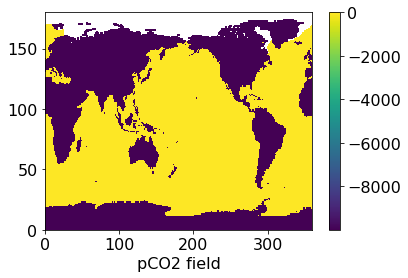

0 [-2788.6627926576316 -2788.662792615567 -2788.6627942337786
 -2788.662793579093 -2788.662792782411 -2788.662791282348
 -2788.6627918467284 -2788.6627906980852 -2788.662792537099
 -2788.6627933500286 -2788.662794362371 -2788.662794721168]
1 [-2788.662792635817 -2788.6627933062236 -2788.662792422826
 -2788.6627927589498 -2788.662793313346 -2788.6627925373978
 -2788.6627924161116 -2788.6627919317984 -2788.662792486405
 -2788.6627938129704 -2788.66279419814 -2788.662793154848]
2 [-2788.6627938145284 -2788.66279326081 -2788.6627944685365
 -2788.6627943404583 -2788.6627937816197 -2788.6627913044663
 -2788.66279056707 -2788.662791382682 -2788.6627932656297
 -2788.662794127317 -2788.6627941323873 -2788.662793737507]
3 [-2788.662792603504 -2788.662792318343 -2788.6627929979954
 -2788.6627934459852 -2788.662793288693 -2788.662791144462
 -2788.662791118138 -2788.6627918039744 -2788.662791609019
 -2788.6627930795844 -2788.6627946697286 -2788.6627929753886]
4 [-2788.6627919998896 -2788.6627933171

In [19]:
# calculate average kwco2 and scale it. then recalculate gas-ex
# not sure if this works properly


kw_ts, kw_am = reg_ave_pCO2(kwco2,'glo_noArc',areaT,YY,reg_arcT)

# convert from m/s to cm/hr
conv_cmhr = 100*60*60

kw_am_cmhr = kw_am * conv_cmhr
kw_tmean = np.nanmean(kw_ts)

In [18]:
print(kw_tmean)
print(np.nanmin(kwco2*100*60*60))
print(np.nanmax(kwco2*100*60*60))

-1003918605.2145804
2.4883108843325443e-11
75.59487094183174


In [16]:
def reg_ave_pCO2(datam,region,areaT,intYY,reg_arcT):
        """
        this function averages a pCO2 fiels over specific regions

        """
        import numpy as np
        from annualmean import annualmean

        print('shape reg_arcT',np.shape(reg_arcT))
        print('shape intYY',np.shape(intYY))

        #-------------------------------------------
        tmp = np.copy(datam)
        print(type(tmp))

        if region == 'global':        # in that case, nothing to do    
            datam_reg = np.copy(tmp)
            print('global, just return from if loop')
 #           print(np.shape(datam_reg))
 #           print(type(datam_reg))
    
        elif region == 'glo_noArc': 
#            tmp[(reg_arcT>0)]=np.nan
            tmp[(reg_arcT[:]>0)] = np.nan
            datam_reg = np.copy(tmp)
            print('global no Arc, apply some mask')
 #           print(np.shape(datam_reg))
 #           print(type(datam_reg))

        elif region == 'S':
            tmp[(intYY[:]>-30)] = np.nan
            datam_reg = np.copy(tmp)

            print('S, apply some mask')
  #          print(np.shape(datam_reg))
  #          print(type(datam_reg))

        elif region == 'N':
            tmp[(intYY[:]<30)] = np.nan
            datam_reg = np.copy(tmp)

            print('N, apply some mask')
   #         print(np.shape(datam_reg))
   #         print(type(datam_reg))

    
        elif region == 'N_noArc':
            tmp[(intYY[:]<30) | (reg_arcT[:]>0.5)] = np.nan
#            tmp[(reg_arcT[:]==1)] = np.nan
            datam_reg = np.ma.array(datam, mask=np.isnan(tmp))

            print('N_noArc, apply some mask')
   #         print(np.shape(datam_reg))
   #         print(type(datam_reg))
    
        elif region == 'N3060':
            tmp[(intYY[:]<30)] = np.nan
            tmp[(intYY[:]>60)] = np.nan
            datam_reg = np.ma.array(datam, mask=np.isnan(tmp))

            print('N3060, apply some mask')
#            print(datam_reg)
#            print(np.shape(datam_reg))
#            print(type(datam_reg))

        elif region == 'N60':
            tmp[(intYY[:]<60)] = np.nan
            datam_reg = np.ma.array(datam, mask=np.isnan(tmp))

            print('N60, apply some mask')
            
        elif region == 'Arc': # changed this to reccap Arc mask
            tmp[(reg_arcT<1)] = np.nan
            datam_reg = np.copy(tmp)
            print('Arc, apply some mask')
#            print(np.shape(datam_reg))
#            print(type(datam_reg))

        elif region == 'T':
            tmp[(intYY[:]<-30)] = np.nan
            tmp[(intYY[:]>30)] = np.nan
            datam_reg = np.ma.array(datam, mask=np.isnan(tmp))

            print('T, apply some mask')
#            print(datam_reg)
#            print(np.shape(datam_reg))
#            print(type(datam_reg))

        else:
            raise NameError('Region not defined properly')
      
        # check with figure
        plt.figure()
        plt.pcolor(np.squeeze(datam_reg[ind1,:,:]))#, vmin=-60, vmax=750)
        plt.colorbar()
        plt.xlabel('pCO2 field')
        plt.show()
        
        # average in space and time
        datam_ts= np.ma.average(np.ma.average(datam_reg,axis=2,weights=areaT),axis=1,weights=np.squeeze(areaT[:,:,0]))
        datam_am = annualmean(datam_ts)
        
        return datam_ts, datam_am